In [1]:
%%capture
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%capture


##  Feedforward Neural Networks (FNNs) for language models

FNNs, or Multi-Layer Perceptrons, serve as the foundational components for comprehending neural networks in natural language processing (NLP). In NLP tasks, FNNs process textual data by transforming it into numerical vectors known as embeddings. Subsequently, these embeddings are input to the network to predict language facets, such as the upcoming word in a sentence or the sentiment of a text.

Let's consider the following song lyrics for our analysis.

In [2]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

# Tokenization for FNN

In [3]:
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer(song)

In [4]:
def preprocess_string(s):

    """
    Preprocesses a given string by performing the following steps:

    1. Removes all non-word characters (excluding letters and numbers).
    2. Removes all whitespace characters.
    3. Removes all numeric digits.

    Parameters:
    s (str): The input string to be cleaned.

    Returns:
    str: The processed string with only alphabetic characters, no spaces, and no digits.
    """

    # Remove all non-word characters (everything except letters and numbers)
    # \w matches any word character (letters, numbers, and underscores)
    # \s matches any whitespace characters
    # ^ inside [] negates the selection, so [^\w\s] matches anything  that's NOT a word character or whitespace.
    s = re.sub(r"[^\w\s]", '', s)

    # Remove all whitespace characters (space, tabs, newlines)
    # \s+ matches one or more whitespaces characters
    s = re.sub(r"\s+", '', s)

    # remove all digits (0, 9)
    # \d matches any digit character
    s = re.sub(r"\d", '', s)

    return s

In [5]:
def preprocess(words):
    """
    Preprocesses a given text by tokenizing it, cleaning individual words, and
    converting them to lowercase while removing empty or punctuation tokens.

    Steps:
    1. Tokenization: Splits the input text into individual word tokens.
    2. Cleaning: Applies `preprocess_string()` to remove non-word characters,
       spaces, and digits from each token.
    3. Normalization: Converts all tokens to lowercase.
    4. Filtering: Removes empty strings and punctuation tokens.

    Parameters:
    words (str): The input text to be tokenized and preprocessed.

    Returns:
    list: A list of cleaned, lowercase tokens.
    """
    # Tokenize the input text into words
    tokens = word_tokenize(words)

    # Apply preprocessing to each token(remove unwanted characters)
    tokens = [preprocess_string(w) for w in tokens]

    # Convert tokens to lowercase and remove empty strings or punctuations
    return [w.lower() for w in tokens if len(w) != 0 and w not in string.punctuation]

# Example usage:
tokens = preprocess(song)

# Indexing

In [6]:
def tokenizetext(song):
    """
    Tokenizes the input text (song) and builds a vocabulary from the tokens.

    Steps:
    1. Tokenization: The function splits the input text into words and applies
       a tokenizer function to each word.
    2. Vocabulary Building: Constructs a vocabulary from the tokenized words,
       including a special "<unk>" token to handle out-of-vocabulary words.
    3. Default Indexing: Sets the default index for unknown words, ensuring
       that any unseen tokens are mapped to "<unk>".

    Parameters:
    song (str): The input text (song lyrics) to be tokenized and processed.

    Returns:
    vocab (Vocab): A vocabulary object mapping tokens to their corresponding indices.
    """
    # Tokenize the text
    # Split the input text into words and apply the tokenizer function to each word.
    # The 'map' function ensures that each word is tokenized properly.

    tokenized_song = map(tokenizer, song.split())

    # Build vocabulary from tokenized text
    # The function `build_vocab_from_iterator` constructs a vocabulary by iterating
    # over the tokenized words. The special token "<unk>" is added to handle words
    # that are not present in the vocabulary.

    vocab = build_vocab_from_iterator(tokenized_song, specials=['<unk>'])

     # Set the default index for unknown words
    # The default index is set to the index of "<unk>" so that any word not found
    # in the vocabulary is mapped to this token, preventing errors during lookup.
    vocab.set_default_index(vocab['<unk>'])

    return vocab

In [7]:
vocab = tokenizetext(song)
print(vocab(tokens[0: 10]))

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]


In [8]:
# text funct that converts raw text into indexes
text_pipeline = lambda x: vocab(tokenizer(x))
print(text_pipeline(song)[0: 10])

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]


In [9]:
# find the word corresponding to an index
index_to_token = vocab.get_itos()
print(index_to_token[58])

are


## Embedding Layers

An embedding layer is a crucial element in natural language processing (NLP) and neural networks designed for sequential data. It serves to convert categorical variables, like words or discrete indexes representing tokens, into continuous vectors. This transformation facilitates training and enables the network to learn meaningful relationships among words.

Let's consider a simple example involving a vocabulary of words

Vocabulary: {apple, banana, orange, pear}
Each word in your vocabulary has a unique index assigned to it:

Indices: {0, 1, 2, 3}
When using an embedding layer, you will initialize random continuous vectors for each index. For instance, the embedding vectors might look like:

Vector for index 0 (apple): [0.2, 0.8]
Vector for index 1 (banana): [0.6, -0.5]
Vector for index 2 (orange): [-0.3, 0.7]
Vector for index 3 (pear): [0.1, 0.4] In PyTorch, you can create an embedding layer.

In [10]:
def genembedding(vocab):
    """
    Generates an embedding layer for the given vocabulary.

    The embedding layer transforms words into dense vector representations,
    allowing the model to learn semantic relationships between words.

    Parameters:
    vocab (Vocab): The vocabulary object containing unique words and their indices.

    Returns:
    nn.Embedding: A PyTorch embedding layer with a specified embedding dimension.
    """

    # Define the embedding dimensions (size of word vectors)
    embedding_dim = 20  # Each word will be represented as a 20-dimensional vector

    # Get the vocabulary size (number of unique words in the vocabulary)
    vocab_size = len(vocab)

    # Create the embedding layer
     # The nn.Embedding module maps word indices to dense vector representations.
    # It takes vocab_size as the number of words and embedding_dim as the vector size.

    embeddings = nn.Embedding(vocab_size, embedding_dim)

    return embeddings

Generating context-target pairs (n-grams)

Organize words within a variable-size context using the following approach: Each word is denoted by 'i'. To establish the context, simply subtract 'j'. The size of the context is determined by the value ofCONTEXT_SIZE.

In [11]:
# Define the context size for generating n-grams
CONTEXT_SIZE = 2 # The number of previous words used to predict the next word

def genngrams(tokens):
    """
    Generates n-grams from a list of tokens, where each n-gram consists of a
    context (previous words) and a target (next word).

    The function constructs a list of tuples where:
    - The first element is a list of `CONTEXT_SIZE` previous words.
    - The second element is the target word that follows the context.

    Parameters:
    tokens (list): A list of preprocessed word tokens.

    Returns:
    list: A list of tuples representing n-grams.
          Each tuple contains (context_words, target_word).
    """

    # Generate n-grams
    # Iterate through the tokens starting from index CONTEXT_SIZE to the end
    # For each token at position 'i', extract the previous CONTEXT_SIZE words as context

    ngrams = [
        (
            [tokens[i - j - 1] for j in range(CONTEXT_SIZE)], # Context words
            tokens[i] # Target word(the word to predict)
        )
        for i in range(CONTEXT_SIZE, len(tokens))
    ]

    return ngrams

In [12]:
ngrams = genngrams(tokens)
context, target = ngrams[0]
print("Context", context, "target", target)
print("context index", vocab(context), "target index", vocab([target]))

Context ['are', 'we'] target no
context index [58, 21] target index [70]


In [13]:
embedding_dim = 20
linear = nn.Linear(embedding_dim*CONTEXT_SIZE, 128)

In [16]:
embeddings = genembedding(vocab)
my_embeddings = embeddings(torch.tensor(vocab(context)))
my_embeddings = my_embeddings.reshape(1, -1)
print(my_embeddings.shape)

torch.Size([1, 40])


In [17]:
# they can be used as inputs in the next layer
linear(my_embeddings)

tensor([[ 1.3919e-02, -1.4083e-01, -4.7991e-01, -5.6367e-01,  1.5046e-01,
         -2.5709e-02,  1.1303e+00,  3.3666e-01,  4.9221e-01,  6.3654e-01,
         -1.5804e-01,  9.2486e-01,  4.5867e-01,  1.4402e+00,  7.9063e-02,
         -9.2064e-01, -8.4613e-01,  3.4789e-01, -9.7873e-02, -2.0134e-02,
          4.9603e-01, -6.0389e-01,  1.0536e-03,  7.6673e-01, -2.7272e-02,
         -5.7740e-01,  2.5591e-01,  4.1911e-01, -8.3956e-02, -9.0079e-02,
         -5.1150e-01, -1.1877e-01,  3.0106e-01, -1.1099e+00,  3.2194e-01,
         -6.8674e-01, -1.3492e-01, -5.9638e-01, -7.8292e-03, -9.9338e-01,
         -2.1995e-01, -1.0299e+00,  1.5097e+00,  2.4814e-01, -2.3497e-01,
         -8.8281e-01, -1.8844e-01, -4.1608e-01,  2.1001e-02,  3.3185e-01,
          3.4671e-01, -6.8888e-01,  6.4894e-01,  5.3734e-01,  3.1916e-01,
          7.1130e-01, -7.7780e-01, -3.4093e-01, -4.7551e-01, -3.3864e-01,
         -8.7504e-02, -5.4339e-01, -2.0069e-02,  1.2535e+00,  2.9524e-01,
         -3.2839e-01,  1.2017e+00, -7.

Batch function

wCreate a Batch function to interface with the data loader. Several adjustments are necessary to handle words that are part of a context in one batch and a predicted word in the following batch.

In [18]:
from torch.utils.data import DataLoader # for batch production
import torch

# Set the devices to GPU if available; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Define the hyperparameters
CONTEXT_SIZE = 3 # number of previous words used as context for prediction
BATCH_SIZE = 10 # Number of samples per training batch
EMBEDDING_DIM = 10 # Dimension of words embeddings

def collate_batch(batch):
    """
    Processes a batch of text data into input (context) and output (target) tensors
    for training a language model.

    The function extracts:
    - `context`: A list of word indices representing the context words for each target word.
    - `target`: A list of word indices representing the target word to predict.

    Parameters:
    batch (list): A list of tokenized words (strings).

    Returns:
    tuple: Two PyTorch tensors: (context_tensor, target_tensor)
           - context_tensor: Tensor of shape (batch_size - CONTEXT_SIZE, CONTEXT_SIZE),
             containing the word indices of context words.
           - target_tensor: Tensor of shape (batch_size - CONTEXT_SIZE,),
             containing the word indices of target words.
    """

    batch_size = len(batch) # Get the size of the batch
    context, target = [], [] # Initialize lists for context and target word

    # Loop through the batch, ensuring enough previous words exist for context

    for i in range(CONTEXT_SIZE, batch_size):
        # Convert the target word to index using the vocabulary
        target.append(vocab([batch[i]]))

        # Convert the previous CONTEXT_SIZE words to indices using the vocabulary
        context.append((vocab([batch[i - j - 1] for j in range(CONTEXT_SIZE)])))

    # Convert lists to PyTorch tensors and move them to the appropriate device
    return torch.tensor(context).to(device), torch.tensor(target).to(device).reshape(-1)


Similarly, it's important to highlight that the size of the last batch could deviate from that of the earlier batches. To tackle this, the approach involves adjusting the final batch to conform to the specified batch size, ensuring it becomes a multiple of the predetermined size. When necessary, you'll employ padding techniques to achieve this harmonization. One approach you'll use is appending the beginning of the song to the end of the batch.

In [19]:
Padding = BATCH_SIZE-len(tokens)%BATCH_SIZE
tokens_pad = tokens + tokens[0: Padding]

Create the DataLoader

In [20]:
dataloader = DataLoader(
    tokens_pad,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)


## Multi-class neural network

You have developed a PyTorch class for a multi-class neural network. The network's output is the probability of the next word within a given context. Therefore, the number of classes corresponds to the count of distinct words. The initial layer consists of embeddings, and in addition to the final layer, an extra hidden layer is incorporated.

In [21]:
class NGramLanguageModeler(nn.Module):
    """
    A neural network-based n-gram language model that predicts the next word
    given a sequence of context words.

    This model consists of:
    - An embedding layer that converts word indices into dense vector representations.
    - A fully connected hidden layer with ReLU activation.
    - An output layer that predicts the probability distribution over the vocabulary.

    Parameters:
    vocab_size (int): The number of unique words in the vocabulary.
    embedding_dim (int): The size of the word embeddings (vector representation of words).
    context_size (int): The number of previous words used as context to predict the next word.
    """
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()

        # Store context size and embedding dimension
        self.context_size = context_size
        self.embedding_dim = embedding_dim

        # Embedding layer: Maps word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Fully connected hidden layer: Maps the concatenated embeddings to a 128-dimensional space
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)

        # Output layer: Maps the hidden layer output to vocabulary size (probability distribution over words)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        """
        Forward pass of the model.

        Parameters:
        inputs (Tensor): A tensor of shape (batch_size, context_size) containing word indices.

        Returns:
        Tensor: A tensor of shape (batch_size, vocab_size) representing predicted probabilities for the next word.
        """

        # Convert input words indices into dense vectors using the embedding layer

        embeds = self.embedding(inputs) # Shape: (batch_size, context_size, embedding_dim)

        # Reshape the embeddings into a single vector per input sample
        embeds = torch.reshape(embeds, (-1, self.context_size * self.embedding_dim))
        # New shape: (batch_size, context_size * embedding_dim)

        # Apply first fully connected layer with ReLU activation
        out = F.relu(self.linear1(embeds)) # Shape: (batch_size, 128)

        # Apply second fully connected layer to generate vocabulary-size logits
        out = self.linear2(out) # Shape: (batch_size, vocab_size)

        return out

Create a model

In [22]:
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

Retrieve samples from the data loader object and input them into the neural network.

In [23]:
context, target = next(iter(dataloader))
print(context, target)
out = model(context)

tensor([[70, 58, 21],
        [74, 70, 58],
        [25, 74, 70],
        [69, 25, 74],
        [ 2, 69, 25],
        [20,  2, 69],
        [31, 20,  2]]) tensor([74, 25, 69,  2, 20, 31, 72])


In [24]:
print(out.shape)

torch.Size([7, 79])



Find the index with the highest probability.

In [25]:
predicted_index = torch.argmax(out, 1)
print(predicted_index)

tensor([ 9, 67, 58, 31, 41, 67, 20])


Find the corresponding token.

In [26]:
[index_to_token[i.item()] for i in predicted_index]

['around', 'guy', 'are', 'the', 'gotta', 'guy', 'know']

In [27]:
def write_song(model, my_song, number_of_words=100):
    """
    Generates text using a trained n-gram language model.

    Given an initial text (`my_song`), the function generates additional words by
    predicting the next word iteratively based on the trained model.

    Parameters:
    model (nn.Module): The trained n-gram language model.
    my_song (str): The initial seed text to start generating words.
    number_of_words (int): The number of words to generate (default: 100).

    Returns:
    str: The generated song lyrics as a string.
    """

    # Get the mapping from index to word for decoding predictions
    index_to_token = vocab.get_itos()

    # Loop to generate the desired number of words
    for i in range(number_of_words):

        with torch.no_grad():  # Disable gradient computation for inference

            # Prepare the input context by extracting the last CONTEXT_SIZE words from tokens
            context = torch.tensor(
                vocab([tokens[i - j - 1] for j in range(CONTEXT_SIZE)])
            ).to(device)  # Move to CPU/GPU as required

            # Predict the next word by selecting the word with the highest probability
            word_idx = torch.argmax(model(context))  # Get index of the most likely next word

            # Append the predicted word to the generated text
            my_song += " " + index_to_token[word_idx.detach().item()]

    return my_song  # Return the generated lyrics


In [28]:
def pickrandomline(song):
    """
    Selects a random line from the given song text.

    This function splits the song into separate lines and randomly picks one of them.

    Parameters:
    song (str): The song lyrics as a multi-line string.

    Returns:
    str: A randomly selected line from the song.
    """

    # Split the song into individual lines
    lines = song.split("\n")

    # Randomly select a line and remove leading/trailing whitespace
    selected_line = random.choice(lines).strip()

    return selected_line  # Return the randomly selected line

# Example usage:
selected_line = pickrandomline(song)  # Pick a random line from the song

# Generate a new song starting with the selected line
generated_song = write_song(model, selected_line)

# Print the generated lyrics
print(generated_song)


Never gonna tell a lie and hurt you long get give around guy are the gotta guy know long the of say it im this know know going know get say this of this know hurt guy guy guy im get weve guy full give commitments know guy guy were are guy weve commitments guy guy full get dont get guy guy it this of guy guy guy this been get gotta get get guy were are been your commitments guy guy been both get guy guy know this the were long get know youre desert commitments long blind it this weve guy know a a this other


## Training

Training a language model involves a multi-step process that leverages training and testing data to optimize model performance. In the realm of Natural Language Processing (NLP), this process often employs various metrics to gauge a model's accuracy, such as perplexity or accuracy on unseen data. However, in the context of your current exploration, you will embark on a slightly different journey. Instead of relying solely on conventional NLP metrics, the focus shifts to manual inspection of the results.

You have the cross entropy loss between input logits and target:

In [29]:
criterion = torch.nn.CrossEntropyLoss()

In [30]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


You have developed a function dedicated to training the model using the supplied data loader. In addition to training the model, the function's output includes predictions for each epoch, spanning context for the next 100 words.

In [31]:
def train(dataloader, model,song,number_of_epochs=100, show=10):
    """
    Args:
        dataloader (DataLoader): DataLoader containing training data.
        model (nn.Module): Neural network model to be trained.
        number_of_epochs (int, optional): Number of epochs for training. Default is 100.
        show (int, optional): Interval for displaying progress. Default is 10.

    Returns:
        list: List containing loss values for each epoch.
    """

    MY_LOSS = []  # List to store loss values for each epoch

    # Iterate over the specified number of epochs
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0  # Initialize total loss for the current epoch
        my_song = ""    # Initialize a string to store the generated song

        # Iterate over batches in the dataloader
        for context, target in dataloader:
            model.zero_grad()          # Zero the gradients to avoid accumulation
            predicted = model(context)  # Forward pass through the model to get predictions
            loss = criterion(predicted, target.reshape(-1))  # Calculate the loss
            total_loss += loss.item()   # Accumulate the loss

            loss.backward()    # Backpropagation to compute gradients
            optimizer.step()   # Update model parameters using the optimizer

        # Display progress and generate song at specified intervals
        if epoch % show == 0:
            selected_line=pickrandomline(song)
            my_song += write_song(model, selected_line)    # Generate song using the model

            print("Generated Song:")
            print("\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))  # Append the total loss for the epoch to MY_LOSS list

    return MY_LOSS  # Return the list of  mean loss values for each epoch

In [32]:
my_loss_list=[]

In [33]:
# Define the context size for the n-gram model
CONTEXT_SIZE = 2

# Create an instance of the NGramLanguageModeler class with specified parameters
model_2 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

# Define the optimizer for training the model, using stochastic gradient descent (SGD)
optimizer = optim.SGD(model_2.parameters(), lr=0.01)

# Set up a learning rate scheduler using StepLR to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

In [34]:
my_loss=train(dataloader,model_2,song)

  1%|█▍                                                                                                                                                   | 1/100 [00:00<01:06,  1.49it/s]

Generated Song:


Never gonna give you up going <unk> to aching i each to <unk> let you get <unk> <unk> wanna <unk> <unk> let get up never let let say let run going let so let <unk> <unk> <unk> <unk> <unk> let gotta <unk> <unk> <unk> <unk> <unk> let going <unk> <unk> <unk> <unk> <unk> down let <unk> <unk> <unk> let <unk> let <unk> <unk> <unk> let <unk> <unk> <unk> going <unk> <unk> <unk> let going <unk> <unk> <unk> <unk> <unk> let <unk> <unk> <unk> let game <unk> <unk> each going let each to never <unk> <unk> going you never i <unk> let game let get <unk>


 11%|████████████████▎                                                                                                                                   | 11/100 [00:03<00:41,  2.16it/s]

Generated Song:


Never gonna run around and desert you <unk> never you never <unk> you you <unk> never never you <unk> you you <unk> <unk> you you never never never never never never never <unk> never never never never <unk> <unk> <unk> tell you never never never <unk> <unk> tell you <unk> never <unk> <unk> tell you <unk> never <unk> <unk> tell you <unk> never <unk> <unk> tell you and <unk> you never <unk> <unk> tell you <unk> never <unk> <unk> tell you you <unk> <unk> tell you <unk> <unk> <unk> you <unk> never <unk> you <unk> <unk> you <unk> you never never <unk> you <unk> you <unk> never


 21%|███████████████████████████████                                                                                                                     | 21/100 [00:07<00:21,  3.68it/s]

Generated Song:


Never gonna let you down never never you never you you you <unk> never never you never you you <unk> <unk> and you never never never and never never never never never never never and <unk> <unk> <unk> tell you never never never <unk> <unk> tell you <unk> never <unk> <unk> tell you <unk> never <unk> <unk> tell you never never <unk> <unk> tell you and <unk> you never <unk> <unk> tell you <unk> never <unk> <unk> tell goodbye never <unk> <unk> tell you <unk> and <unk> you never never and you <unk> <unk> you never you never never <unk> you <unk> you <unk> never


 32%|███████████████████████████████████████████████▎                                                                                                    | 32/100 [00:09<00:11,  5.74it/s]

Generated Song:


Never gonna give you up never never you strangers to you you down never never and desert you you <unk> <unk> and you never never never and down never never down never never never and <unk> <unk> <unk> tell you never never never <unk> <unk> tell you never never <unk> <unk> tell you <unk> never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you never never <unk> <unk> tell goodbye never <unk> <unk> tell you <unk> and hurt you never never and you <unk> and you never you never never <unk> youre <unk> you <unk> never


 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 42/100 [00:13<00:16,  3.61it/s]

Generated Song:


Never gonna run around and desert you never never you strangers to you you down never game and desert you you <unk> <unk> and you never never im down down never never down never we never and <unk> <unk> <unk> tell you never never never <unk> <unk> tell you never never <unk> <unk> tell you down never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you never never <unk> <unk> tell goodbye never <unk> <unk> tell you <unk> and hurt you never never and never for and you never you never never <unk> youre too shy to and


 52%|████████████████████████████████████████████████████████████████████████████▉                                                                       | 52/100 [00:14<00:06,  7.26it/s]

Generated Song:


Inside we both know whats been going on never never no strangers to you you down never game and desert you feeling <unk> <unk> and what never never im down down never never down im other guy and <unk> <unk> <unk> tell you never im feeling <unk> <unk> tell you never never <unk> <unk> tell you know never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you never never <unk> <unk> tell goodbye never <unk> <unk> tell you lie and hurt you never never and never for and you your you been aching <unk> youre too shy to and


 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 61/100 [00:16<00:07,  5.19it/s]

Generated Song:


Gotta make you understand never never no strangers to you you down whats game and desert you feeling <unk> <unk> and what im never im down down never strangers feeling im other guy and <unk> <unk> <unk> tell you how im feeling <unk> <unk> tell you understand never <unk> <unk> tell you know never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you lie and hurt you never never each never for goodbye you your you been aching <unk> youre too shy to and


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 71/100 [00:18<00:07,  3.77it/s]

Generated Song:


Never gonna make you cry never never no strangers to love you down the game and were you feeling <unk> <unk> and what im feeling im down down never strangers feeling im other guy and <unk> <unk> <unk> tell you how im feeling <unk> <unk> tell you understand never <unk> <unk> tell you know never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you lie and hurt you never never each other for so you your you been aching <unk> youre too shy to and


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 82/100 [00:20<00:02,  8.81it/s]

Generated Song:


Never gonna give you up never are no strangers to love you down the game and were you feeling <unk> <unk> and what im feeling im we down never this feeling im other guy i <unk> <unk> <unk> tell you how im feeling <unk> <unk> tell you understand never <unk> <unk> tell you know never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you lie and hurt you never known each other for so you your hearts been aching <unk> youre too shy to say


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 91/100 [00:21<00:01,  7.49it/s]

Generated Song:


Never gonna tell a lie and hurt you never are no strangers to love you down the game and were you feeling <unk> <unk> and what im thinking im we down never this from im other guy i <unk> <unk> <unk> tell you how im feeling <unk> <unk> tell you understand never <unk> <unk> tell you up never <unk> <unk> tell you down never <unk> <unk> tell you and desert you never <unk> <unk> tell you understand never <unk> <unk> tell goodbye never <unk> <unk> tell you lie and hurt you never known each other for so you your hearts been aching but youre too shy to say


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


Save the model

In [35]:
save_path = '2gram.pth'
torch.save(model_2.state_dict(), save_path)
my_loss_list.append(my_loss)

The code provided below shows word embeddings from the created model, reduces their dimensionality to 2D using t-SNE, and then plots them as a scatter plot. Additionally, it annotates the first 20 points in the visualization with their corresponding words. This is used to visualize how similar words cluster together in a lower-dimensional space, revealing the structure of the word embeddings. Embeddings allow the model to represent words in a continuous vector space, capturing semantic relationships and similarities between words.



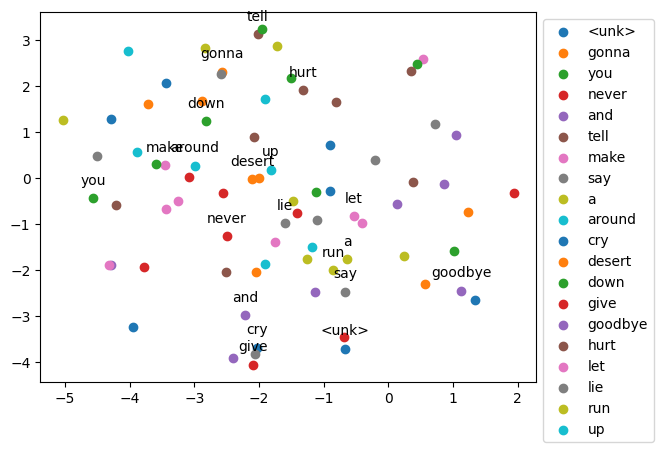

In [36]:
X = model_2.embedding.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Finally, for a context of eight.

In [37]:
CONTEXT_SIZE=8
model_8 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_8.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_8,song)

save_path = '8gram.pth'
torch.save(model_8.state_dict(), save_path)

my_loss_list.append(my_loss)

  1%|█▍                                                                                                                                                   | 1/100 [00:00<00:18,  5.42it/s]

Generated Song:


Never gonna say goodbye <unk> <unk> <unk> <unk> <unk> <unk> <unk> of <unk> feeling both goodbye <unk> <unk> wanna <unk> of <unk> for <unk> rules <unk> strangers <unk> <unk> rules <unk> strangers youre for how strangers tell <unk> <unk> <unk> commitments rules strangers <unk> on you your and <unk> weve tell you <unk> <unk> <unk> <unk> you you strangers <unk> <unk> <unk> you im <unk> <unk> <unk> <unk> both <unk> make you for <unk> <unk> <unk> you <unk> you <unk> <unk> tell <unk> <unk> strangers <unk> <unk> <unk> how <unk> <unk> you <unk> it <unk> your im <unk> strangers <unk> im it <unk> <unk>


 12%|█████████████████▊                                                                                                                                  | 12/100 [00:01<00:11,  7.63it/s]

Generated Song:


Never gonna make you cry <unk> <unk> <unk> give to im tell tell <unk> rules <unk> <unk> <unk> <unk> tell <unk> give you im tell <unk> <unk> you <unk> <unk> <unk> <unk> you guy i <unk> you tell <unk> you you tell feeling <unk> <unk> give you never never <unk> <unk> give you up never <unk> <unk> give you you never <unk> <unk> give you <unk> tell <unk> <unk> tell <unk> make you <unk> never <unk> <unk> give you you <unk> <unk> tell you <unk> give <unk> <unk> <unk> you <unk> give <unk> so long you <unk> <unk> <unk> you <unk> too shy to <unk>


 21%|███████████████████████████████                                                                                                                     | 21/100 [00:02<00:07, 10.51it/s]

Generated Song:


Never gonna make you cry <unk> never <unk> strangers to im tell im the rules <unk> to on <unk> play it give you im thinking im give you <unk> <unk> <unk> <unk> you guy i <unk> you <unk> <unk> you you im feeling <unk> <unk> give you never never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> give around <unk> never <unk> <unk> im <unk> make you cry never <unk> <unk> give you you never <unk> tell a lie never <unk> <unk> <unk> never <unk> other for so long to im <unk> <unk> never <unk> too shy to say


 32%|███████████████████████████████████████████████▎                                                                                                    | 32/100 [00:03<00:07,  9.22it/s]

Generated Song:


Never gonna say goodbye <unk> too shy strangers to im tell im the rules <unk> to on guy play it give you im thinking im <unk> cry im <unk> <unk> <unk> you guy i strangers you <unk> <unk> you up im feeling <unk> <unk> give you never never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> im <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> never im other for so long to im <unk> <unk> lie <unk> too shy to say


 41%|████████████████████████████████████████████████████████████▋                                                                                       | 41/100 [00:04<00:05,  9.95it/s]

Generated Song:


Your hearts been aching but youre too shy to say it <unk> the shy strangers to im tell feeling the rules <unk> to on guy play it give you im thinking im a cry im <unk> <unk> <unk> you guy i strangers you <unk> <unk> a up im feeling <unk> <unk> give you never never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> im <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> never im other for so long feeling im <unk> <unk> lie the too shy to say


 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                     | 53/100 [00:05<00:04, 10.75it/s]

Generated Song:


Never gonna run around and desert you <unk> the shy strangers to im tell feeling the rules <unk> to on guy play it give you im thinking im a cry the <unk> <unk> <unk> you guy i strangers you <unk> <unk> a up im feeling <unk> <unk> give you never never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> im <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> never im other for so long feeling im <unk> <unk> lie the too shy to say


 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 62/100 [00:06<00:03,  9.52it/s]

Generated Song:


Never gonna run around and desert you <unk> the shy strangers to im tell feeling the rules <unk> to on guy play it give you im thinking im a cry the <unk> <unk> <unk> you guy i strangers you <unk> <unk> a up im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> im <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> never im other for so long feeling im <unk> <unk> lie the too shy to say


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 73/100 [00:08<00:03,  8.67it/s]

Generated Song:


We are no strangers to love <unk> the shy strangers to im tell feeling the rules <unk> to on guy play it give you im thinking im a cry the <unk> <unk> <unk> you guy i strangers you <unk> <unk> a up im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> im <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> never im other for so long feeling im <unk> <unk> lie the too shy to say


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 81/100 [00:09<00:02,  9.20it/s]

Generated Song:


Never gonna say goodbye <unk> the shy strangers to im tell we the rules <unk> to on guy play it give you im thinking im a cry the <unk> <unk> <unk> you guy i strangers you <unk> <unk> a up im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> im <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> never im other for so long feeling im <unk> <unk> lie the too shy to say


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 93/100 [00:10<00:00,  9.30it/s]

Generated Song:


Never gonna let you down <unk> the shy strangers to im tell we the rules <unk> to long guy play it give you im thinking im a cry the <unk> <unk> <unk> you guy i strangers you <unk> <unk> a up im feeling <unk> <unk> give you cry never <unk> <unk> give you up never <unk> <unk> give you up never <unk> <unk> run around up never <unk> <unk> im <unk> make you cry never <unk> <unk> give you up never <unk> tell a lie never <unk> <unk> <unk> never im other for so long feeling im <unk> <unk> lie the too shy to say


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.62it/s]


The code provided below shows word embeddings from the created model, reduces their dimensionality to 2D using t-SNE, and then plots them as a scatter plot. Additionally, it annotates the first 20 points in the visualization with their corresponding words. This is used to visualize how similar words cluster together in a lower-dimensional space, revealing the structure of the word embeddings. Embeddings allow the model to represent words in a continuous vector space, capturing semantic relationships and similarities between words.



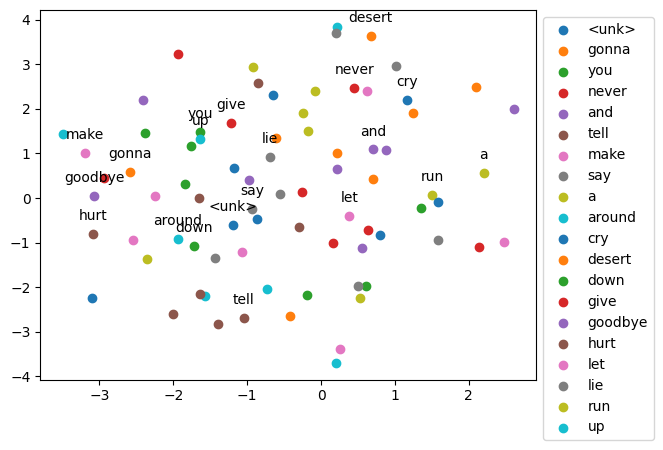

In [39]:
X = model_8.embedding.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Perplexity
Perplexity is a measurement used to evaluate the effectiveness of language models or probability models. It provides an indication of how well a model predicts a sample of data or the likelihood of an unseen event. Perplexity is commonly used in natural language processing tasks, such as machine translation, speech recognition, and language generation.

Perplexity is derived from the concept of cross-entropy loss, which measures the dissimilarity between predicted probabilities and actual probabilities.

$$\text{Cross-Entropy Loss} = -\sum_{i=1}^{N} y_i \ln(p_i)$$
The cross-entropy loss is calculated by taking the negative sum of the products of the true labels $y_i$ and the logarithm of the predicted probabilities $p_i$ over $N$ classes.

Taking the exponential of the mean cross-entropy loss gives us the perplexity value.

$$\text{Perplexity} = e^{\frac{1}{N} \text{Cross-Entropy Loss}}$$


A lower perplexity value indicates that the model is more confident and accurate in predicting the data. Conversely, a higher perplexity suggests that the model is less certain and less accurate in its predictions.

Perplexity can be seen as an estimate of the average number of choices the model has for the next word or event in a sequence. A lower perplexity means that the model is more certain about the next word, while a higher perplexity means that there are more possible choices.


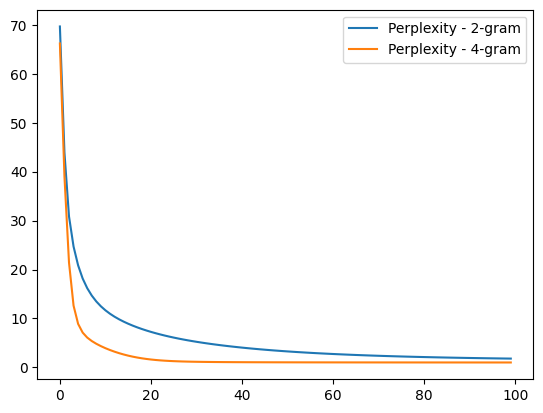

In [40]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    # Calculate perplexity using the loss
    perplexity = np.exp(my_loss)
    plt.plot(perplexity,label="Perplexity - {}".format(model_name))
    plt.legend()